In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.display.max_seq_items = 2000
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime as dt
import calendar

In [2]:
data = pd.read_csv("./training_data_wPreds.csv")
data['record_dummy'] = 1
data['dt_month_year'] = [dt(year, month, 1) for month, year in zip(data.time_sale_month_of_year, data.time_sale_year)]
data.shape


/var/folders/q9/v0k4_bgj7d31b7zlsnys9hsh0000gn/T/ipykernel_14489/1817893754.py:1: DtypeWarning: Columns (101,104) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("./training_data_wPreds.csv")


(379713, 179)

In [8]:
data.columns

Index(['meta_sale_price', 'meta_sale_date', 'meta_sale_document_num',
       'meta_sale_deed_type', 'meta_sale_seller_name', 'meta_sale_buyer_name',
       'meta_sale_count_past_n_years', 'meta_pin', 'meta_pin10', 'meta_year',
       'meta_class', 'meta_modeling_group', 'meta_triad_name',
       'meta_triad_code', 'meta_township_name', 'meta_township_code',
       'meta_nbhd_code', 'meta_tax_code', 'meta_tieback_key_pin',
       'meta_tieback_proration_rate', 'ind_pin_is_prorated', 'meta_card_num',
       'ind_pin_is_multicard', 'meta_pin_num_cards', 'ind_pin_is_multiland',
       'meta_pin_num_landlines', 'hie_num_active', 'meta_cdu',
       'meta_mailed_bldg', 'meta_mailed_land', 'meta_mailed_tot',
       'meta_certified_bldg', 'meta_certified_land', 'meta_certified_tot',
       'meta_board_bldg', 'meta_board_land', 'meta_board_tot',
       'meta_1yr_pri_board_bldg', 'meta_1yr_pri_board_land',
       'meta_1yr_pri_board_tot', 'meta_2yr_pri_board_bldg',
       'meta_2yr_pri_board_land

In [3]:
keep_cols = ['time_sale_year', 'time_sale_month_of_year',
             'record_dummy', 'meta_sale_price', 'pred_card_initial_fmv',
             'squared_pred_error', 'abs_pred_error']
time_split = data[keep_cols].groupby(['time_sale_year', 'time_sale_month_of_year']).sum().reset_index()
time_split['dt_month_year'] = [dt(year, month, 1) for month, year in zip(time_split.time_sale_month_of_year, time_split.time_sale_year)]
time_split['avg_sales_price'] = time_split.meta_sale_price / time_split.record_dummy
time_split['avg_pred_sales_price'] = time_split.pred_card_initial_fmv / time_split.record_dummy
time_split['axis_lbl'] = [f"{calendar.month_abbr[month]} {year}" for month, year in zip(time_split.time_sale_month_of_year, time_split.time_sale_year)]
time_split['dt_month_year'] = [dt(year, month, 1) for month, year in zip(time_split.time_sale_month_of_year, time_split.time_sale_year)]
time_split['num_date'] = [int(f"{year}0{month}") if month < 10 else int(f"{year}{month}") for month, year in zip(time_split.time_sale_month_of_year, time_split.time_sale_year) ]
time_split['record_std'] = time_split.record_dummy / time_split.record_dummy.sum()
time_split['sq_pred_err_std'] = time_split.squared_pred_error / time_split.squared_pred_error.sum()
time_split.shape


(108, 14)

In [4]:
var_val_dict = time_split[['dt_month_year', 'avg_sales_price', 'avg_pred_sales_price', 'record_dummy']].set_index('dt_month_year').T.to_dict()

def compute_mean_sq_diff(row:pd.Series, 
                         var_val_dict:dict=var_val_dict,
                         pred:bool=False):
    if pred: sales_col, mean_key = 'pred_card_initial_fmv', 'avg_pred_sales_price'
    else: sales_col, mean_key = 'meta_sale_price', 'avg_sales_price'
    
    month_year = row['dt_month_year']
    mean = var_val_dict[month_year][mean_key]
    
    return ( row[sales_col] - mean )**2

def compute_single_month_variance(month_data:pd.DataFrame,
                                  var_val_dict:dict=var_val_dict,
                                  pred:bool=False):
    n_obs = len(month_data)
    squared_mean_diffs = month_data.apply(lambda row: compute_mean_sq_diff(row=row,
                                                                           var_val_dict=var_val_dict,
                                                                           pred=pred), axis=1)
    
    return squared_mean_diffs.sum().item() / n_obs

def construct_partial_month_variance_df(df:pd.DataFrame,
                                        var_val_dict:dict=var_val_dict,
                                        pred:bool=False):
    months = df.dt_month_year.unique()
    m_variances = []
    for m in months:
        month_data = df[ df.dt_month_year == m ]
        month_variance = compute_single_month_variance(month_data=month_data,
                                                       var_val_dict=var_val_dict,
                                                       pred=pred)
        m_variances.append(month_variance)
    
    if pred: variance_col_name = 'predicted_sales_variance'
    else: variance_col_name = 'observed_sales_variance'
    variance_df = pd.DataFrame({'dt_month_year': months,
                                variance_col_name: m_variances})
    return variance_df

def construct_full_month_variance_df(df:pd.DataFrame,
                                     var_val_dict:dict=var_val_dict):
    pred_variance = construct_partial_month_variance_df(df=df,
                                                        var_val_dict=var_val_dict,
                                                        pred=True)
    observed_variance = construct_partial_month_variance_df(df=df,
                                                            var_val_dict=var_val_dict,
                                                            pred=False)
    full_variance_df = pred_variance.merge(observed_variance, on='dt_month_year', how='outer')
    
    return full_variance_df


In [5]:
full_variance_df = construct_full_month_variance_df(df=data,
                                                   var_val_dict=var_val_dict)
full_variance_df.shape


(108, 3)

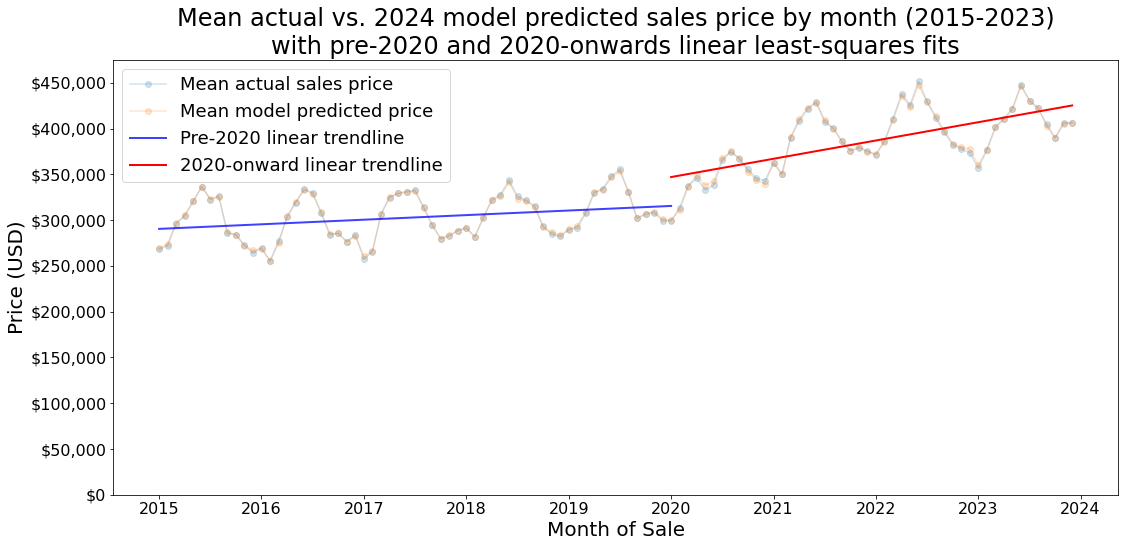

In [7]:
plt.rcParams["figure.figsize"] = (18,8)
x = mdates.date2num(time_split.dt_month_year)
y_t = time_split.avg_sales_price
y_p = time_split.avg_pred_sales_price

lin_params = np.polyfit(x, y_t, deg=1)
quad_params = np.polyfit(x, y_t, deg=2)
lin_fit = np.poly1d(lin_params)
quad_fit = np.poly1d(quad_params)

pre_pandemmic_params = np.polyfit(x[:5*12+1], y_t[:5*12+1], deg=1)
post_pandemmic_params = np.polyfit(x[5*12:], y_t[5*12:], deg=1)
pre_pandemic_fit = np.poly1d(pre_pandemmic_params)
post_pandemic_fit = np.poly1d(post_pandemmic_params)

xx = np.linspace(x.min(), x.max()+1, 9*12)
dd = mdates.num2date(xx)

plt.plot(dd, y_t, marker='o', label='Mean actual sales price', alpha=0.2)
plt.plot(dd, y_p, marker='o', label='Mean model predicted price', alpha=0.2)

#plt.plot(dd, lin_fit(xx), label="Linear trendline", c='green', linewidth=2)
#plt.plot(dd, quad_fit(xx), label="Quadratic trendline", c='purple', linewidth=2)
plt.plot(dd[:5*12+1], pre_pandemic_fit(xx[:5*12+1]), label="Pre-2020 linear trendline", c='blue', alpha=0.75, linewidth=2)
plt.plot(dd[5*12:], post_pandemic_fit(xx[5*12:]), label="2020-onward linear trendline", c='red', linewidth=2)

plt.ylim(0, 475000)
y_ticks = np.arange(0, 500000, 50000)
y_labels = [f'${tick:,}' for tick in y_ticks]
plt.yticks(ticks=y_ticks, labels=y_labels, fontsize=16, rotation=0)

#x_ticks = np.arange(2015, 2025, 1)
#x_labels = [str(tick) for tick in x_ticks]
#plt.xticks(ticks=x_ticks, labels=x_labels, fontsize=14, rotation=0)
plt.tick_params(axis='x', which='both', labelsize=16)

plt.title("Mean actual vs. 2024 model predicted sales price by month (2015-2023)\nwith pre-2020 and 2020-onwards linear least-squares fits", fontsize=24)
plt.xlabel("Month of Sale", fontsize=20)
plt.ylabel("Price (USD)", fontsize=20)

plt.legend(prop={'size': 18})
plt.show()


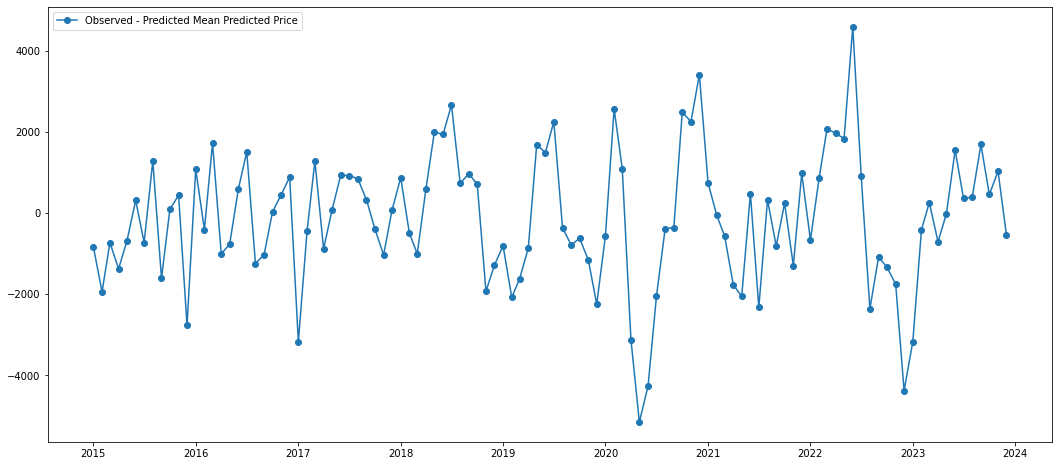

In [8]:
plt.rcParams["figure.figsize"] = (18,8)
x = time_split.dt_month_year
y_t = time_split.avg_sales_price
y_p = time_split.avg_pred_sales_price
plt.plot(x, y_t - y_p, marker='o', label='Observed - Predicted Mean Predicted Price', alpha=1)
plt.legend()
plt.show()


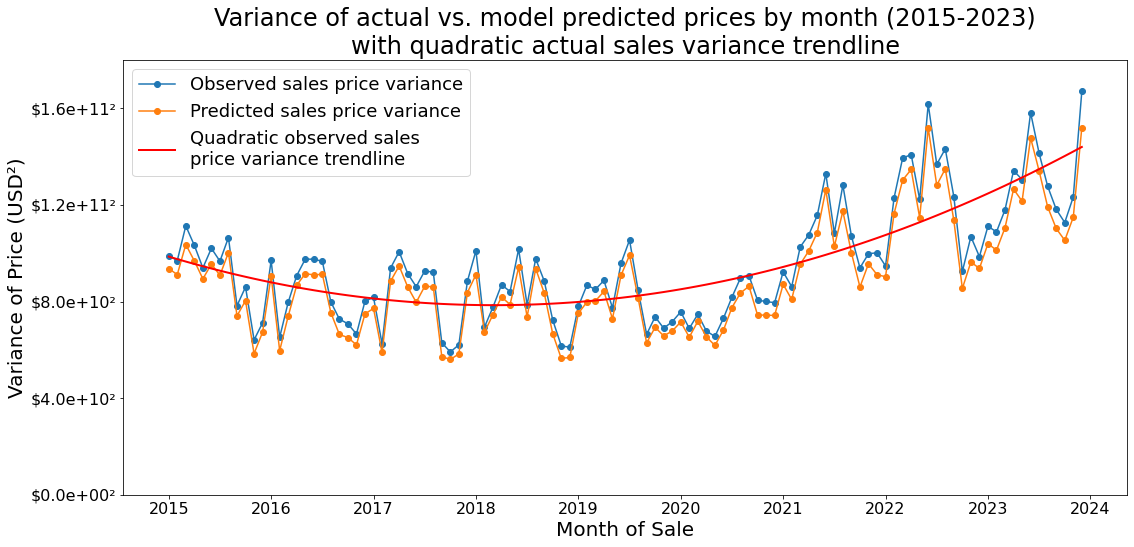

In [9]:
plt.rcParams["figure.figsize"] = (18,8)
x = full_variance_df.dt_month_year
y_t = full_variance_df.observed_sales_variance
y_p = full_variance_df.predicted_sales_variance

x = mdates.date2num(time_split.dt_month_year)

quad_params = np.polyfit(x, y_t, deg=2)
quad_fit = np.poly1d(quad_params)

xx = np.linspace(x.min(), x.max()+1, 9*12)
dd = mdates.num2date(xx)

plt.plot(dd, y_t, marker='o', label='Observed sales price variance', alpha=1)
plt.plot(dd, y_p, marker='o', label='Predicted sales price variance', alpha=1)
plt.plot(dd, quad_fit(xx), label="Quadratic observed sales\nprice variance trendline", c='red', linewidth=2)

plt.ylim(0, 1.8e11)
y_ticks = np.arange(0, 1.8e11, 0.4e11)
y_labels = [f"${tick:.1e}\N{SUPERSCRIPT TWO}" for tick in y_ticks]
plt.yticks(ticks=y_ticks, labels=y_labels, fontsize=16, rotation=0)
#plt.tick_params(axis='y', which='both', labelsize=16)

#x_ticks = np.arange(2015, 2025, 1)
#x_labels = [str(tick) for tick in x_ticks]
#plt.xticks(ticks=x_ticks, labels=x_labels, fontsize=14, rotation=0)
plt.tick_params(axis='x', which='both', labelsize=16)


plt.title("Variance of actual vs. model predicted prices by month (2015-2023)\nwith quadratic actual sales variance trendline", fontsize=24)
plt.xlabel("Month of Sale", fontsize=20)
plt.ylabel(f"Variance of Price (USD\N{SUPERSCRIPT TWO})", fontsize=20)

plt.legend(prop={'size': 18})
plt.show()


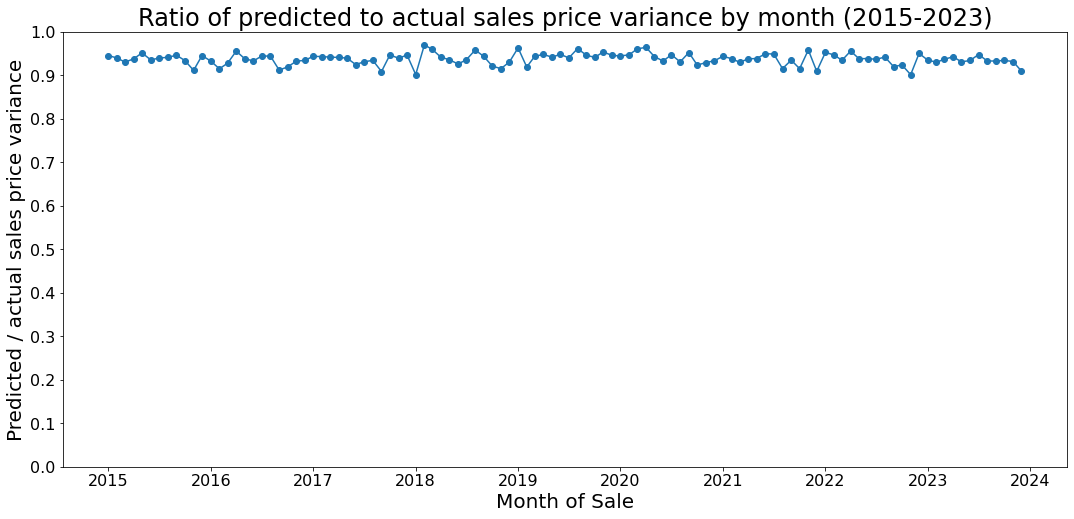

In [20]:
plt.rcParams["figure.figsize"] = (18,8)
x = full_variance_df.dt_month_year
y_t = full_variance_df.observed_sales_variance
y_p = (full_variance_df.predicted_sales_variance)
plt.plot(x, y_p / y_t, marker='o', label='Ratio of Predicted / Observed Sales Variance', alpha=1)

y_ticks = np.arange(0, 1.1, 0.1)
y_labels = [f'{tick:.1f}' for tick in y_ticks]
plt.yticks(y_ticks, y_labels, fontsize=16)

plt.tick_params(axis='x', which='both', labelsize=16)
#plt.tick_params(axis='y', which='both', labelsize=16)

plt.title("Ratio of predicted to actual sales price variance by month (2015-2023)", fontsize=24)
plt.xlabel("Month of Sale", fontsize=20)
plt.ylabel(f"Predicted / actual sales price variance", fontsize=20)

plt.ylim(0,1)
# plt.legend()
plt.show()


In [19]:
(y_p / y_t).mean()

np.float64(0.9377220224572013)

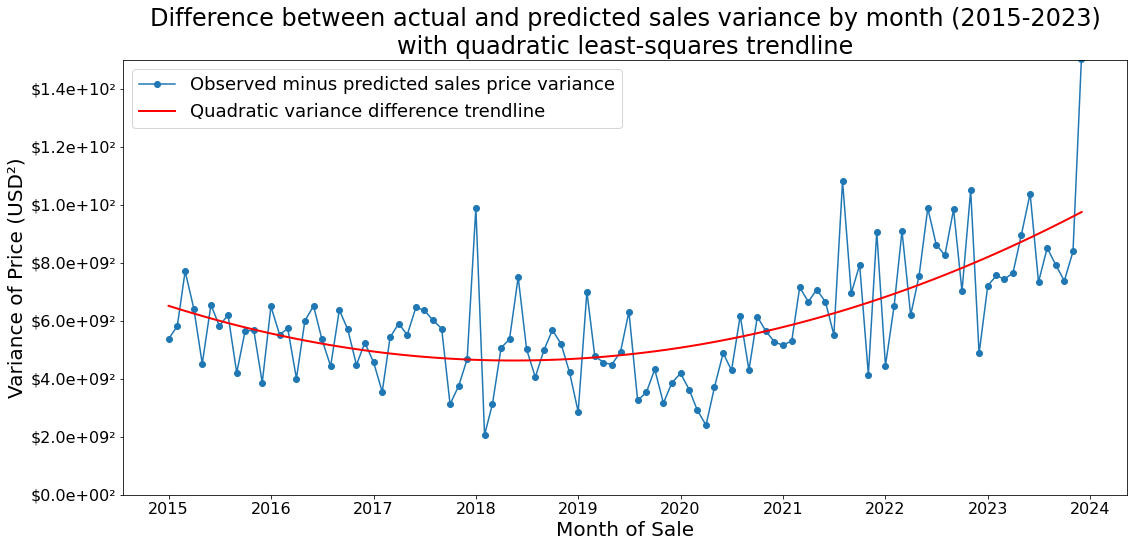

In [39]:
plt.rcParams["figure.figsize"] = (18,8)
x = mdates.date2num(time_split.dt_month_year)
y_t = full_variance_df.observed_sales_variance
y_p = (full_variance_df.predicted_sales_variance)
plt.plot(x, y_t - y_p, marker='o', label='Observed minus predicted sales price variance', alpha=1)

quad_params = np.polyfit(x, y_t - y_p, deg=2)
quad_fit = np.poly1d(quad_params)

xx = np.linspace(x.min(), x.max()+1, 9*12)
dd = mdates.num2date(xx)

plt.plot(dd, quad_fit(xx), label="Quadratic variance difference trendline", c='red', linewidth=2)

y_ticks = np.arange(0, 1.6e10, 0.2e10)
y_labels = [f"${tick:.1e}\N{SUPERSCRIPT TWO}" for tick in y_ticks]
plt.yticks(ticks=y_ticks, labels=y_labels, fontsize=16, rotation=0)
plt.tick_params(axis='x', which='both', labelsize=16)

plt.title("Difference between actual and predicted sales variance by month (2015-2023)\nwith quadratic least-squares trendline", fontsize=24)
plt.xlabel("Month of Sale", fontsize=20)
plt.ylabel(f"Variance of Price (USD\N{SUPERSCRIPT TWO})", fontsize=20)

plt.ylim(0, 1.5e10)
plt.legend(prop={'size': 18})
plt.show()


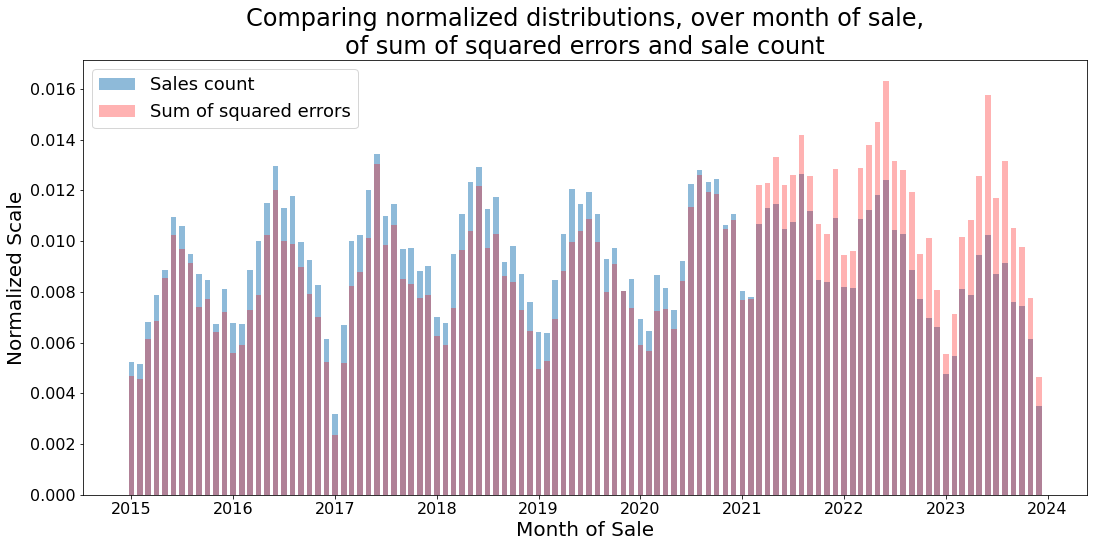

In [42]:
plt.rcParams["figure.figsize"] = (18,8)
x = time_split.dt_month_year
y1 = time_split.record_std
#y1 = full_variance_df.observed_sales_variance / full_variance_df.observed_sales_variance.sum()
y2 = time_split.sq_pred_err_std

plt.bar(x=x, height=y1, width=20, alpha=0.5, label='Sales count')
plt.bar(x=x, height=y2, width=20, color='r', alpha=0.3, label='Sum of squared errors')

plt.tick_params(axis='x', which='both', labelsize=16)
plt.tick_params(axis='y', which='both', labelsize=16)

plt.title("Comparing normalized distributions, over month of sale,\nof sum of squared errors and sale count", fontsize=24)
plt.xlabel("Month of Sale", fontsize=20)
plt.ylabel(f"Normalized Scale", fontsize=20)

plt.legend(prop={'size': 18})
plt.show()


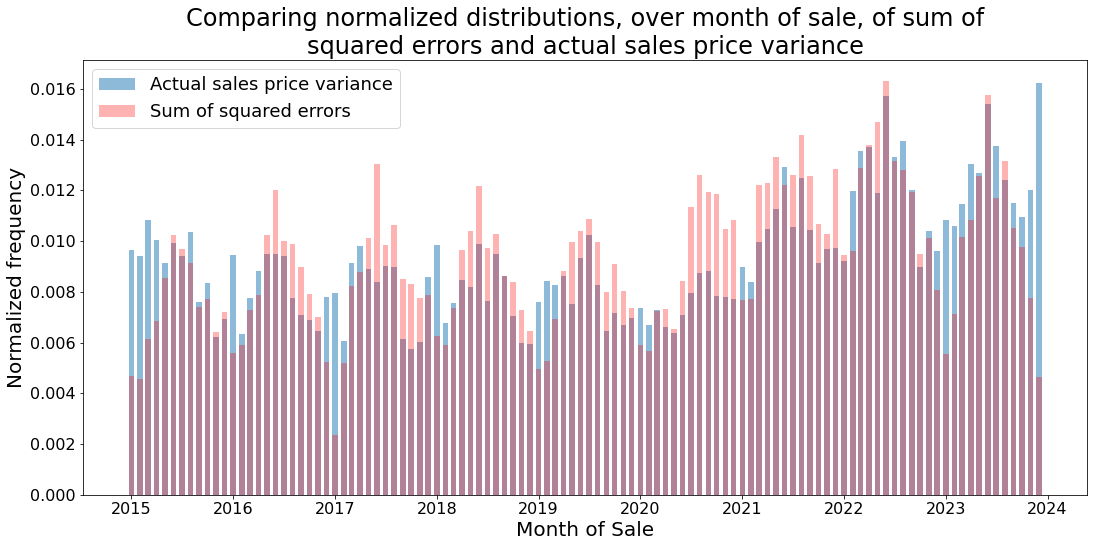

In [18]:
plt.rcParams["figure.figsize"] = (18,8)
x = time_split.dt_month_year
#y1 = time_split.record_std
y1 = full_variance_df.observed_sales_variance / full_variance_df.observed_sales_variance.sum()
y2 = time_split.sq_pred_err_std

plt.tick_params(axis='x', which='both', labelsize=16)
plt.tick_params(axis='y', which='both', labelsize=16)

plt.title("Comparing normalized distributions, over month of sale, of sum of\nsquared errors and actual sales price variance", fontsize=24)
plt.xlabel("Month of Sale", fontsize=20)
plt.ylabel(f"Normalized Scale", fontsize=20)

plt.bar(x=x, height=y1, width=20, alpha=0.5, label='Actual sales price variance')
plt.bar(x=x, height=y2, width=20, color='r', alpha=0.3, label='Sum of squared errors')
plt.legend(prop={'size': 18})
plt.show()


In [ ]:
pre_pandemic = time_split[ time_split.num_date < 202101 ]
post_pandemic = time_split[ time_split.num_date >= 202101 ]

pre_diff = (pre_pandemic.record_std - pre_pandemic.sq_pred_err_std).sum().item()
post_diff = (post_pandemic.record_std - post_pandemic.sq_pred_err_std).sum().item()

pre_diff, post_diff


(0.0762617467643874, -0.0762617467643873)

In [58]:
np.corrcoef(y1, y2)

array([[1.        , 0.78450322],
       [0.78450322, 1.        ]])

In [96]:
tx = [1,1,3,3,4,4,5,6,6,7,8,8,8,8,9,9,9,10,10]
ty = [3*v + 2 for v in tx]
noise = np.random.normal(0,0.2,len(tx))
ty = [v+n for v,n in zip(ty, noise)]
m, b = np.polyfit(tx, ty, deg=1)
pred_ty = [m*v+b for v in tx]
errors = np.array([(real_y - py)**2 for real_y, py in zip(ty, pred_ty)])
errors_dist = errors / errors.sum()
freq_dist = np.bincount(tx) / np.bincount(tx).sum()
freq_x = np.arange(0, len(freq_dist))


In [ ]:
abs(noise) / abs(noise).sum()

array([0.020467  , 0.12895831, 0.09277605, 0.04600049, 0.03524125,
       0.05503737, 0.00589196, 0.01753075, 0.02064701, 0.00308414,
       0.02049074, 0.02279213, 0.04549448, 0.10976564, 0.07238432,
       0.01601872, 0.18669841, 0.01965559, 0.08106563])

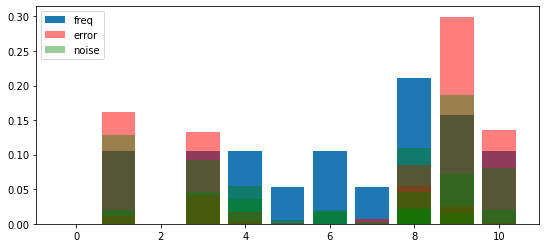

In [ ]:
plt.bar(x=freq_x, height=freq_dist, label='freq')
plt.bar(x=tx, height=errors_dist, label='error', alpha=0.5, color='r')
plt.bar(x=tx, height=abs(noise) / abs(noise).sum(), label='noise', alpha=0.4, color='green')
plt.legend()
plt.show()


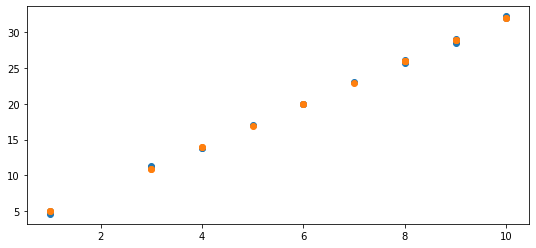

In [ ]:
plt.rcParams["figure.figsize"] = (9,4)
plt.scatter(tx, ty)
plt.scatter(tx, pred_ty)
plt.show()